# Final Project

# Introduction

Name: Karina Maharani Utomo 
<br>
Batch: 003 
<br>
Hactiv8 Full Time Data Science

This Final Project utilises a Goodreads dataset that can be accessed [here](https://www.kaggle.com/meetnaren/goodreads-best-books)

The dataset includes information about a book's title, author, description, edition, format, isbn, number of pages, average rating, number of ratings, reviews, genres, and cover

The problem:
As a reader, when choosing a new book to read, the genre of the book usually plays a big part in the decision-making process. That is why for writers or publishers, it is important to correctly choose the genres that their books belong in. This is to make sure that the book they’re publishing reaches the right audience and in turn, boosting its sales and advertising

This project is created with the focus of recommending genre tags that best fit a book, based on its description

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install langdetect
from langdetect import detect

from sklearn.model_selection import train_test_split
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix , classification_report

import joblib

# Data Loading

To make the model building process easier, we will only be using book descriptions that are written in English

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/data hacktiv8/cleaned_book_data.csv')
data.head()

,Unnamed: 0,index,book_authors,book_title,book_desc,genres,language,language_name
0,0,0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English
1,1,1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English
2,2,2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English
3,3,4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English
4,4,5,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English


In [4]:
data['language_name'].value_counts()

English    43792
Name: language_name, dtype: int64

# Data Exploration

In this dataset, each book has a list of genres. These genres need to be separated from each other, so that the amount of unique genres in this dataset and the amount of genres a book has can be counted

In [5]:
print('List of genres from the dataset    :', data.loc[0]['genres'])
print('The genres after they\'re separated:', data.loc[0]['genres'].split('|'))
print('The amount of genres in that book  :', len(data.loc[0]['genres'].split('|')))

List of genres from the dataset    : Young Adult|Fiction|Science Fiction|Dystopia|Fantasy|Science Fiction
The genres after they're separated: ['Young Adult', 'Fiction', 'Science Fiction', 'Dystopia', 'Fantasy', 'Science Fiction']
The amount of genres in that book  : 6


In [6]:
# Function to count the number of genres in a book

def num_of_genres(x):
  return len(x.split('|'))

data['num_of_genres'] = data['genres'].map(lambda x: num_of_genres(x))

In [7]:
data.head()

,Unnamed: 0,index,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres
0,0,0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6
1,1,1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3
2,2,2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6
3,3,4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8
4,4,5,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4


In [8]:
data.drop(columns = ['Unnamed: 0', 'index'], inplace = True)
data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4


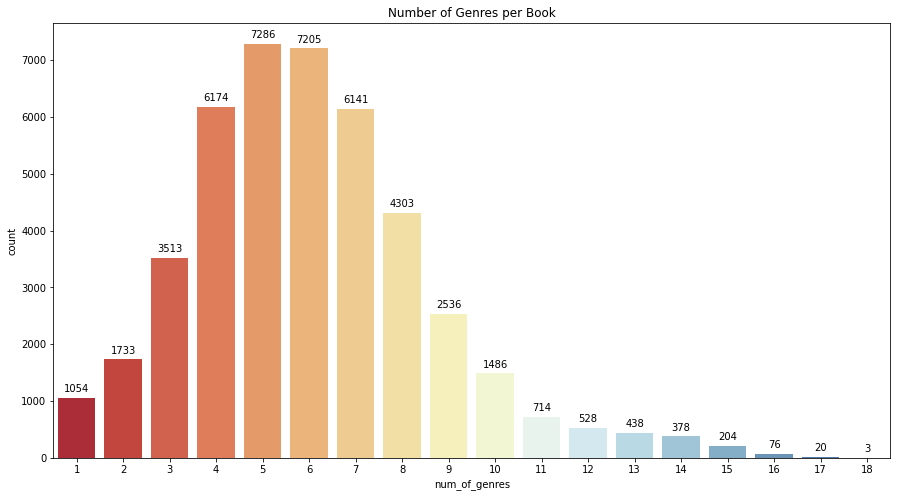

In [9]:
plt.figure(figsize = (15,8))

num_plot = sns.countplot(x = data['num_of_genres'], palette = 'RdYlBu')
for p in num_plot.patches:
    num_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Number of Genres per Book')
    
plt.show()

Most of the books are classified into 5-6 different genres. There is also a few books that are classified into 16-18 genres

In [10]:
# Function to separate the genres in a book

def list_of_genres(x):
  return (x.split('|'))

data['list_of_genres'] = data['genres'].map(lambda x: list_of_genres(x))
data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop..."
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]"
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic..."
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va..."
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn..."


In [11]:
data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop..."
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]"
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic..."
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va..."
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn..."


In [12]:
# Listing all the unique genres in this dataset

gens = set()
for i in range(len(data)):
  for j in range(len(data['list_of_genres'][i])):
      gens.add(data['list_of_genres'][i][j])

In [13]:
# Counting the number of books in each genre

gen_dict = {i:0 for i in gens}

for i in range(len(data)):
    for j in range(len(data['list_of_genres'][i])):
        gen_dict[data['list_of_genres'][i][j]]+=1

In [14]:
len(gen_dict)

850

There is a total of 850 different genres in this dataset. Here are the top 5 genres

In [15]:
gen_pd = pd.DataFrame.from_records(sorted(gen_dict.items(), key = lambda x:x[1], reverse=True), 
                                     columns=['genre', 'count'])
gen_pd.head()

,genre,count
0,Fiction,22338
1,Fantasy,21629
2,Romance,17357
3,Young Adult,10296
4,Historical,9693


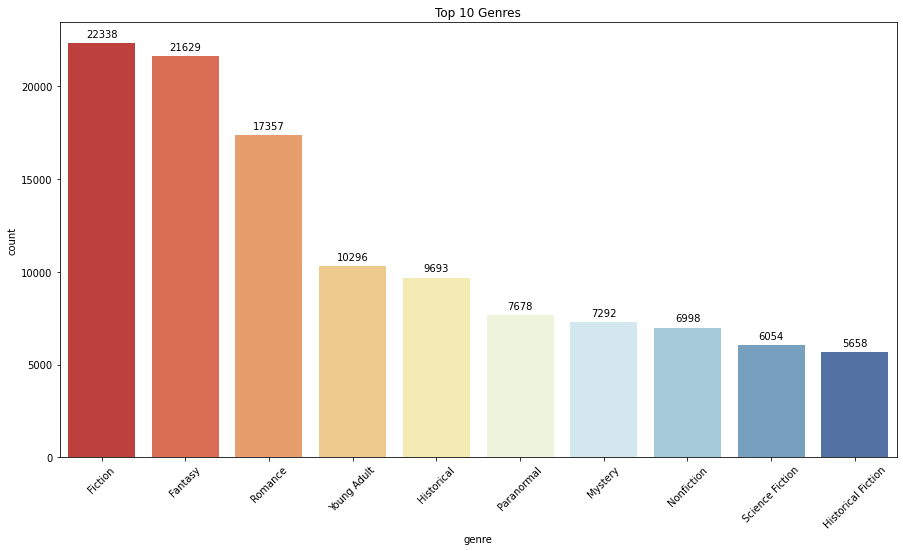

In [16]:
gen_10 = gen_pd[:10]

plt.figure(figsize = (15,8))

gen_plot = sns.barplot(data = gen_10, x = gen_10['genre'], y = gen_10['count'], palette = 'RdYlBu')
for p in gen_plot.patches:
    gen_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.title('Top 10 Genres')

plt.show()

From the top 10 genres, two of them are 'Fiction' and 'Nonfiction'. Since every book can be classified into one of those two classes, we will split the data into those two classes to see the top genres in each class

So for the next step, a new column will be added to label the book as simply Fiction or Nonfiction. The books that don't have 'Fiction' or 'Nonfiction' in their list of genres will be labeled as 'Not Determined'

In [17]:
def determine_label(x):
    if 'Fiction' in x:
        return 'Fiction'
    elif 'Nonfiction' in x:
        return 'Nonfiction'
    else:
        return 'Not Determined'

In [18]:
data['label'] = data['list_of_genres'].apply(determine_label)
data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",Fiction
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",Fiction
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic...",Fiction
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",Fiction
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn...",Fiction


In [19]:
fiction = data[data['label'] == 'Fiction'].reset_index()
fiction.shape

(22338, 10)

In [20]:
data['list_of_genres'][43731]

['Nonfiction',
 'Biography',
 'Autobiography',
 'Memoir',
 'Humor',
 'Biography',
 'Autobiography',
 'Humor',
 'Comedy']

There are 22337 books that are classified as Fiction in this dataset

In [21]:
fic_gens = set()
for i in range(len(fiction)):
  for j in range(len(fiction['list_of_genres'][i])):
      fic_gens.add(fiction['list_of_genres'][i][j])

In [22]:
fic_gen_dict = {i:0 for i in fic_gens}

for i in range(len(fiction)):
    for j in range(len(fiction['list_of_genres'][i])):
        fic_gen_dict[fiction['list_of_genres'][i][j]]+=1

In [23]:
len(fic_gen_dict)

605

For the fictional books, there are 605 unique genres. The top 5 (including 'Fiction') are as follows:

In [24]:
fic_gen_pd = pd.DataFrame.from_records(sorted(fic_gen_dict.items(), key = lambda x:x[1], reverse=True), 
                                     columns=['fiction genre', 'count'])
fic_gen_pd.head(6)

,fiction genre,count
0,Fiction,22338
1,Fantasy,9971
2,Historical,7445
3,Mystery,5876
4,Young Adult,5095
5,Historical Fiction,4766


In [25]:
nonfiction = data[data['label'] == 'Nonfiction'].reset_index()
nonfiction.shape

(6998, 10)

As for the Nonfiction, there are 7000 books that are classified in that genre

In [26]:
nonfic_gens = set()
for i in range(len(nonfiction)):
  for j in range(len(nonfiction['list_of_genres'][i])):
      nonfic_gens.add(nonfiction['list_of_genres'][i][j])

In [27]:
nonfic_gen_dict = {i:0 for i in nonfic_gens}

for i in range(len(nonfiction)):
    for j in range(len(nonfiction['list_of_genres'][i])):
        nonfic_gen_dict[nonfiction['list_of_genres'][i][j]]+=1

In [28]:
len(nonfic_gen_dict)

565

There are 565 unique genres for the non-fictional books. The top 6 (including 'Nonfiction') are as follows:

In [29]:
nonfic_gen_pd = pd.DataFrame.from_records(sorted(nonfic_gen_dict.items(), key = lambda x:x[1], reverse=True), 
                                     columns=['nonfiction genre', 'count'])
nonfic_gen_pd.head(6)

,nonfiction genre,count
0,Nonfiction,6998
1,Biography,2427
2,History,2349
3,Religion,1925
4,Autobiography,1913
5,Memoir,1538


Below are the distribution of genres for the fictional and non-fictional books

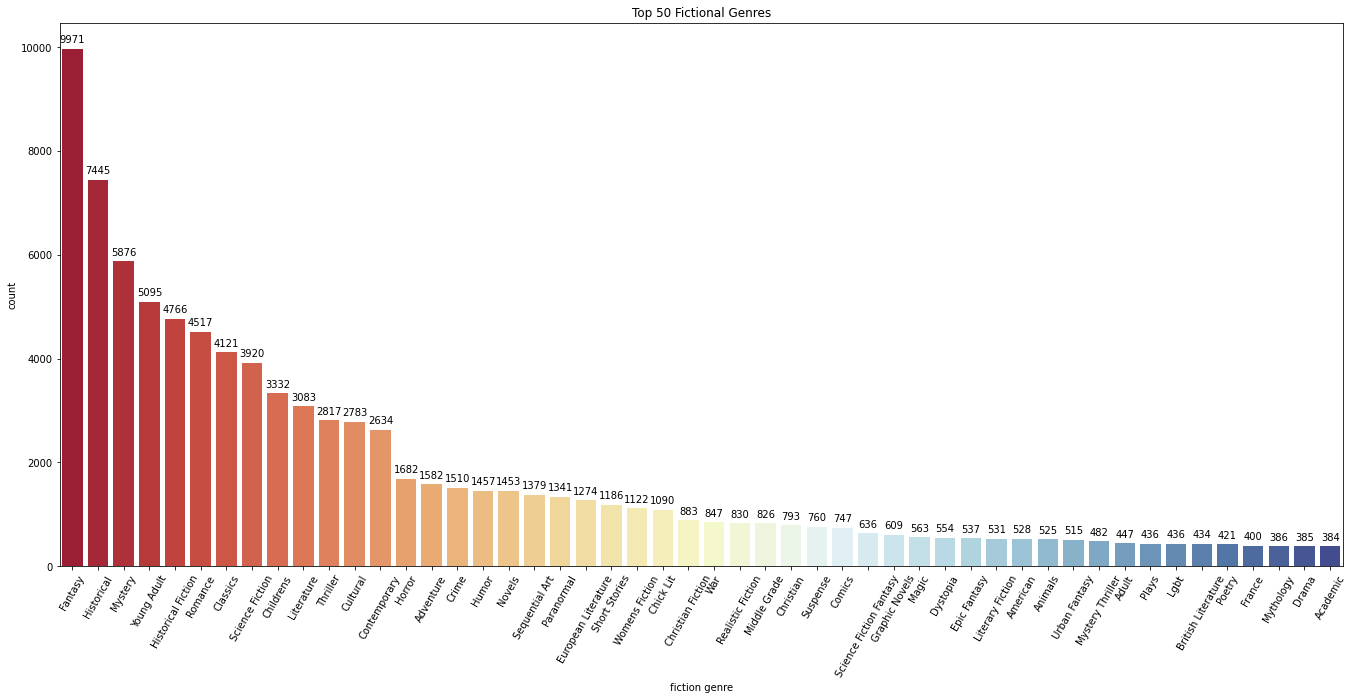

In [30]:
fic_gen_50 = fic_gen_pd[1:51]

plt.figure(figsize = (23,10))

fic_gen_plot = sns.barplot(data = fic_gen_50, x = fic_gen_50['fiction genre'], y = fic_gen_50['count'], palette = 'RdYlBu')
for p in fic_gen_plot.patches:
    fic_gen_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=60)
plt.title('Top 50 Fictional Genres')

plt.show()

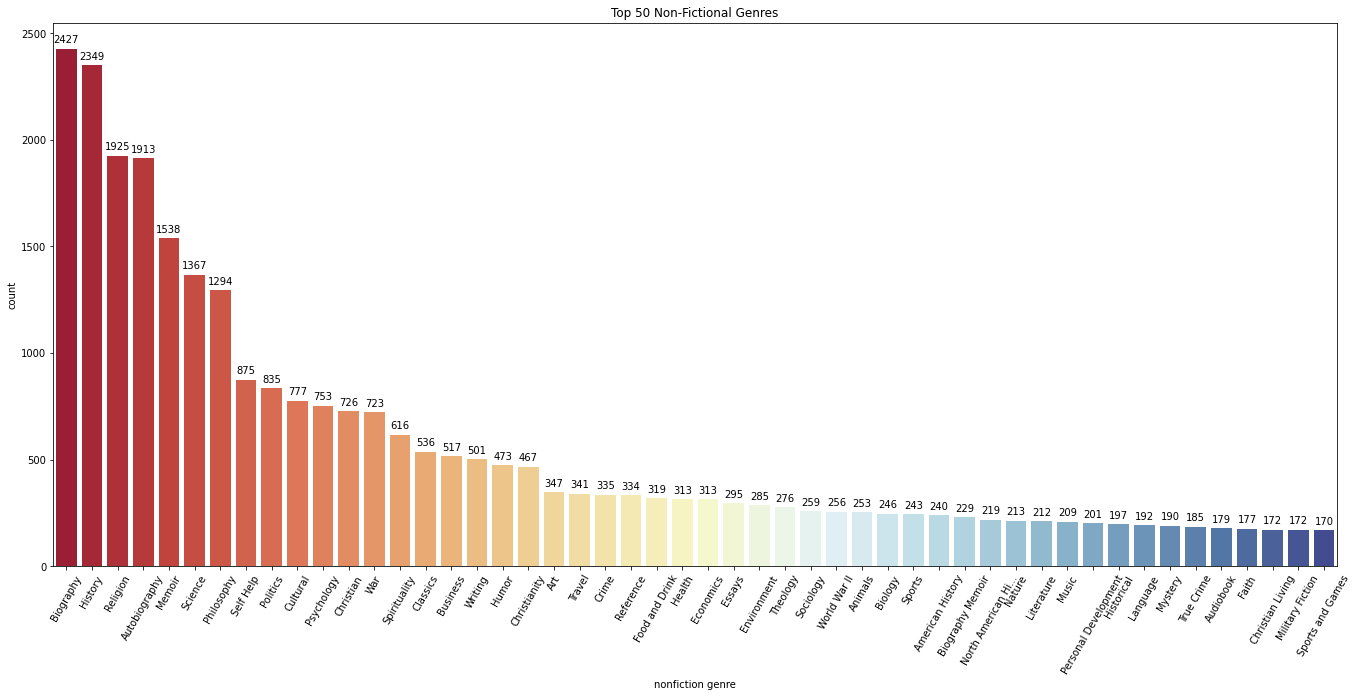

In [31]:
nonfic_gen_50 = nonfic_gen_pd[1:51]

plt.figure(figsize = (23,10))

nonfic_gen_plot = sns.barplot(data = nonfic_gen_50, x = nonfic_gen_50['nonfiction genre'], y = nonfic_gen_50['count'], palette = 'RdYlBu')
for p in nonfic_gen_plot.patches:
    nonfic_gen_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=60)
plt.title('Top 50 Non-Fictional Genres')

plt.show()

# Data Preprocessing

To save time, we won't be using all unique genres for the model building process. Instead, we will be choosing the top 5 genres from each Fiction and Nonfiction books. We will also include 'Fiction' and 'Nonfiction', so there will be 12 genres in total

This is to ensure that the model can predict a variety of both Fiction and Nonfiction books

In [32]:
top_fic = fic_gen_pd['fiction genre'][1:6].tolist()
top_fic

['Fantasy', 'Historical', 'Mystery', 'Young Adult', 'Historical Fiction']

In [33]:
top_nonfic = nonfic_gen_pd['nonfiction genre'][1:6].tolist()
top_nonfic

['Biography', 'History', 'Religion', 'Autobiography', 'Memoir']

For Fiction books, since 'Historical' and 'Historical Fiction' are essentially the same genre, the former will be renamed into the latter. That leaves us with one empty spot in out list of top 5 Fictional genres. That means we can add the 6th top fictional genre to the list, which is 'Romance'

A similar thing applies to the Nonfiction books. We will group 'Biography', 'Autobiography', and 'Memoir' into one genre, which is 'Biography'. That means 'Religion', 'Science', and 'Philosophy' can be added to the top 5 Nonfictional genres

In [34]:
cleaned_data = data.copy()

In [35]:
for i in range(len(cleaned_data)):
  for j in range(len(cleaned_data['list_of_genres'][i])):
    if cleaned_data['list_of_genres'][i][j] == 'Historical':
      cleaned_data['list_of_genres'][i][j] = 'Historical Fiction'
    elif cleaned_data['list_of_genres'][i][j] == 'Autobiography':
      cleaned_data['list_of_genres'][i][j] = 'Biography'
    elif cleaned_data['list_of_genres'][i][j] == 'Memoir':
      cleaned_data['list_of_genres'][i][j] = 'Biography'

In [36]:
top_genre = ['Fiction', 'Fantasy', 'Mystery', 'Young Adult', 'Historical Fiction', 'Romance',
             'Nonfiction', 'Biography', 'History', 'Religion', 'Science', 'Philosophy']

Next, the description of the book needs to be cleaned. That means turn all letters into lowercase, replace shortened words with their formal form (for example: i'm will be turned into i am), filtering out punctuations, removing numbers, and removing non-ascii characters

In [37]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def cleaner(df):
    df['clean_desc'] = df['book_desc'].apply(clean_text)
    return df

In [38]:
cleaned_data = cleaner(cleaned_data)
cleaned_data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label,clean_desc
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",Fiction,winning will make you famous losing means cert...
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",Fiction,there is a door at the end of a silent corrido...
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical Fiction, Histor...",Fiction,the unforgettable novel of a childhood in a sl...
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",Fiction,about three things i was absolutely positive f...
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical Fiction, Historical Fiction, Ficti...",Fiction,trying to make sense of the horrors of world w...


The next step is to encode the genre labels. First add 12 columns, 1 for each genre, with default values of 0

In [39]:
encoded_data = cleaned_data.copy()

In [40]:
for genre in top_genre:
    encoded_data.loc[:, genre] = 0

In [41]:
encoded_data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label,clean_desc,Fiction,Fantasy,Mystery,Young Adult,Historical Fiction,Romance,Nonfiction,Biography,History,Religion,Science,Philosophy
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",Fiction,winning will make you famous losing means cert...,0,0,0,0,0,0,0,0,0,0,0,0
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",Fiction,there is a door at the end of a silent corrido...,0,0,0,0,0,0,0,0,0,0,0,0
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical Fiction, Histor...",Fiction,the unforgettable novel of a childhood in a sl...,0,0,0,0,0,0,0,0,0,0,0,0
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",Fiction,about three things i was absolutely positive f...,0,0,0,0,0,0,0,0,0,0,0,0
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical Fiction, Historical Fiction, Ficti...",Fiction,trying to make sense of the horrors of world w...,0,0,0,0,0,0,0,0,0,0,0,0


After that, the `list_of_genres` column will be encoded into a binary representation in the 12 genre columns. 1 means that genre is present in `list_of_genres` and 0 means the opposite

In [42]:
for i in encoded_data.index:
    for genre in top_genre:
        encoded_data.loc[encoded_data.index == i, genre] = int(genre in encoded_data['list_of_genres'][i])
    if i % 100 == 0:
        print(i, end='\r')

In [43]:
encoded_data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label,clean_desc,Fiction,Fantasy,Mystery,Young Adult,Historical Fiction,Romance,Nonfiction,Biography,History,Religion,Science,Philosophy
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",Fiction,winning will make you famous losing means cert...,1,1,0,1,0,0,0,0,0,0,0,0
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",Fiction,there is a door at the end of a silent corrido...,1,1,0,1,0,0,0,0,0,0,0,0
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical Fiction, Histor...",Fiction,the unforgettable novel of a childhood in a sl...,1,0,0,0,1,0,0,0,0,0,0,0
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",Fiction,about three things i was absolutely positive f...,1,1,0,1,0,1,0,0,0,0,0,0
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical Fiction, Historical Fiction, Ficti...",Fiction,trying to make sense of the horrors of world w...,1,0,0,1,1,0,0,0,0,0,0,0


In [44]:
encoded_data.tail()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label,clean_desc,Fiction,Fantasy,Mystery,Young Adult,Historical Fiction,Romance,Nonfiction,Biography,History,Religion,Science,Philosophy
43787,Avi Steinberg,Running the Books: The Adventures of an Accide...,Avi Steinberg is stumped. After defecting from...,Nonfiction|Autobiography|Memoir|Biography|Writ...,en,English,7,"[Nonfiction, Biography, Biography, Biography, ...",Nonfiction,avi steinberg is stumped after defecting from ...,0,0,0,0,0,0,1,1,0,0,0,0
43788,Howard Megdal,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...",Sports|Baseball|Sports and Games|Sports|Nonfic...,en,English,5,"[Sports, Baseball, Sports and Games, Sports, N...",Nonfiction,in this fearless and half crazy story howard m...,0,0,0,0,0,0,1,0,0,0,0,0
43789,Howard Megdal,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,Nonfiction|Sports and Games|Sports,en,English,3,"[Nonfiction, Sports and Games, Sports]",Nonfiction,from the icons of the game to the players who ...,0,0,0,0,0,0,1,0,0,0,0,0
43790,Mimi Baird|Eve Claxton,He Wanted the Moon: The Madness and Medical Ge...,"Soon to be a major motion picture, from Brad P...",Nonfiction|Autobiography|Memoir|Biography|Psyc...,en,English,9,"[Nonfiction, Biography, Biography, Biography, ...",Nonfiction,soon to be a major motion picture from brad pi...,0,0,0,0,0,0,1,1,0,0,0,0
43791,Leah Price,The Anthology and the Rise of the Novel: From ...,The Anthology and the Rise of the Novel brings...,Criticism|Literary Criticism|Philosophy|Theory...,en,English,9,"[Criticism, Literary Criticism, Philosophy, Th...",Not Determined,the anthology and the rise of the novel brings...,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
cols = list(encoded_data.columns.values)
genre_cols = cols[10:]
print(len(genre_cols))
print(genre_cols)

12
['Fiction', 'Fantasy', 'Mystery', 'Young Adult', 'Historical Fiction', 'Romance', 'Nonfiction', 'Biography', 'History', 'Religion', 'Science', 'Philosophy']


## Splitting Data

The data will be split into training, validation data, and test data

In [46]:
X = encoded_data['clean_desc']
y = encoded_data[genre_cols].values

In [47]:
X1, X_test, y1, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.1, random_state = 42, shuffle=True)

In [48]:
# Melihat hasil splitting data

print('Precentage of data used for training data  :', '%.2f' % ((len(X_train)/len(X))*100), '%')
print('Precentage of data used for validation data:', '%.2f' % ((len(X_val)/len(X))*100), '%')
print('Precentage of data used for test data      :', '%.2f' % ((len(X_test)/len(X))*100), '%')
print()

print('Amount of rows in training data  :', X_train.shape[0])
print('Amount of rows in validation data:', X_val.shape[0])
print('Amount of rows in test data      :', X_test.shape[0])

Precentage of data used for training data  : 85.50 %
Precentage of data used for validation data: 9.50 %
Precentage of data used for test data      : 5.00 %

Amount of rows in training data  : 37441
Amount of rows in validation data: 4161
Amount of rows in test data      : 2190


## Preprocessing Training Data

This is what's going to be done in the preprocessing stage:
- **Removing stopwords**: Stopwords are often added to sentences to make them grammatically correct, for example, words such as a, is, an, the, and etc. These stopwords carry minimal to no importance and are available plenty on open texts, articles, comments etc. These should be removed so machine learning algorithms can better focus on words which define the meaning/idea of the text. We are using list from nltk.corpus and this list can further be enhanced by adding or removing custom words based on the situation at hand
- **Splitting sentence into words with a tokenizer**: Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the list of sentences or words in a string
- **Lemmatization**: Lemmatization is an advanced form of stemming. Stemming might not result in actual word, whereas lemmatization does conversion properly with the use of vocabulary, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, eating will be replaced by eat

[reference](https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0)

In [49]:
X_train_trf = X_train.copy()

In [50]:
# download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
x_tokenized = []
stop_words = set(stopwords.words("english"))
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

for x in X_train_trf.values:
  tmp = []
  sent_token = sent_tokenize(x)
  for sents in sent_token:
    word_token = tokenizer.tokenize(sents)
    filtered = [w.strip() for w in word_token if w not in stop_words and len(w) > 1]
    for words in filtered:
      lemm = lemmatizer.lemmatize(words)
      words = lemm
    tmp.extend(filtered)
  x_tokenized.append(tmp)

In [52]:
X_train_trf.values[0]

'a story of a girl a boy and the universenatasha i m a girl who believes in science and facts not fate not destiny or dreams that will never come true i m definitely not the kind of girl who meets a cute boy on a crowded new york city street and falls in love with him not when my family is twelve hours away from being deported to jamaica falling in love with him won t be my story daniel i ve always been the good son the good student living up to my parents high expectations never the poet or the dreamer but when i see her i forget about all that something about natasha makes me think that fate has something much more extraordinary in store for both of us the universe every moment in our lives has brought us to this single moment a million futures lie before us which one will come true'

In [53]:
len(x_tokenized[0])

76

The description above is now turned into a list of a few words as seen below

Note: reshaping the list so it will be nicer to see

In [54]:
np.reshape(x_tokenized[0], newshape = (1,len(x_tokenized[0])))

array([['story', 'girl', 'boy', 'universenatasha', 'girl', 'believes',
        'science', 'facts', 'fate', 'destiny', 'dreams', 'never', 'come',
        'true', 'definitely', 'kind', 'girl', 'meets', 'cute', 'boy',
        'crowded', 'new', 'york', 'city', 'street', 'falls', 'love',
        'family', 'twelve', 'hours', 'away', 'deported', 'jamaica',
        'falling', 'love', 'story', 'daniel', 'always', 'good', 'son',
        'good', 'student', 'living', 'parents', 'high', 'expectations',
        'never', 'poet', 'dreamer', 'see', 'forget', 'something',
        'natasha', 'makes', 'think', 'fate', 'something', 'much',
        'extraordinary', 'store', 'us', 'universe', 'every', 'moment',
        'lives', 'brought', 'us', 'single', 'moment', 'million',
        'futures', 'lie', 'us', 'one', 'come', 'true']], dtype='<U15')

After the description of each book is split into words, the next step is to encode each word into numbers

In [55]:
t = Tokenizer()
t.fit_on_texts(x_tokenized)

In [56]:
X_train_seq = t.texts_to_sequences(x_tokenized)

In [57]:
np.reshape(X_train_seq[0], newshape = (1,len(x_tokenized[0])))

array([[    7,    44,    88, 56526,    44,   733,   303,  2316,   227,
          436,   191,    16,    67,    86,  2077,   320,    44,   231,
         2856,    88,  5978,     3,    61,    74,   704,   480,     5,
           11,   807,   924,    89, 14386,  9960,   615,     5,     7,
         1352,   117,    79,   161,    79,   658,   136,   194,   110,
         2832,    16,  1014,  7073,   129,   775,    82,  7329,   162,
          307,   227,    82,    73,   251,  1973,    65,   562,    48,
          387,    35,   470,    65,   441,   387,   799,  5918,  1015,
           65,     1,    67,    86]])

In [58]:
word_index = t.word_index
for word, num in word_index.items():
    print(f"{word}: {num}")
    if num == 5:
        break

one: 1
life: 2
new: 3
world: 4
love: 5


To make sure each book description has the same amount of words in its list, we will set the length to 1.5 times the mean of number of words in a book description after preprocessing. The number we get is 120. So if a length of a book description is more than that, it will be trimmed. If the length is shorter, we will fill the gap with paddings

In [59]:
tem = 0
for i in range(len(X_train_seq)):
    tem += len(X_train_seq[i])
invec = int(1.5*tem/len(X_train_seq))

In [60]:
invec

120

In [61]:
X_train_pad = pad_sequences(X_train_seq, maxlen=invec)

In [62]:
np.reshape(X_train_seq[0], newshape = (1,len(x_tokenized[0])))

array([[    7,    44,    88, 56526,    44,   733,   303,  2316,   227,
          436,   191,    16,    67,    86,  2077,   320,    44,   231,
         2856,    88,  5978,     3,    61,    74,   704,   480,     5,
           11,   807,   924,    89, 14386,  9960,   615,     5,     7,
         1352,   117,    79,   161,    79,   658,   136,   194,   110,
         2832,    16,  1014,  7073,   129,   775,    82,  7329,   162,
          307,   227,    82,    73,   251,  1973,    65,   562,    48,
          387,    35,   470,    65,   441,   387,   799,  5918,  1015,
           65,     1,    67,    86]])

In [63]:
len(X_train_seq[0])

76

In this case, the length of a book description is 76. That means we have to fill the remaining 44 spaces, to make it have a length of 120

In [64]:
X_train_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     7,
          44,    88, 56526,    44,   733,   303,  2316,   227,   436,
         191,    16,    67,    86,  2077,   320,    44,   231,  2856,
          88,  5978,     3,    61,    74,   704,   480,     5,    11,
         807,   924,    89, 14386,  9960,   615,     5,     7,  1352,
         117,    79,   161,    79,   658,   136,   194,   110,  2832,
          16,  1014,  7073,   129,   775,    82,  7329,   162,   307,
         227,    82,    73,   251,  1973,    65,   562,    48,   387,
          35,   470,    65,   441,   387,   799,  5918,  1015,    65,
           1,    67,    86], dtype=int32)

In [65]:
len(X_train_pad[0])

120

After that, we make a weight matrix using Word2Vec vector and keras tokenizer index. This will be used later in the model building section

In [66]:
w2v_model = Word2Vec(sentences=x_tokenized, min_count=5, workers=4)

In [67]:
vocab_size = len(t.word_index) + 1

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, w2v_model.vector_size))
    for word, i in vocab.items():
        if word not in model:
            weight_matrix[i] = 0
        else:
            weight_matrix[i] = model[word]
    return weight_matrix

emvec = get_weight_matrix(w2v_model.wv, word_index)

Finally, to make the preprocessing step easier for validation data & model inference, all the steps that have been done on the training data will be compiled into one function

In [68]:
def tokenize_data(df):
  x_tokenized = []
  stop_words = set(stopwords.words("english"))
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer()

  for x in df.values:
    tmp = []
    sent_token = sent_tokenize(x)
    for sents in sent_token:
      word_token = tokenizer.tokenize(sents)
      filtered = [w.strip() for w in word_token if w not in stop_words and len(w) > 1]
      for words in filtered:
        lemm = lemmatizer.lemmatize(words)
        words = lemm
      tmp.extend(filtered)
    x_tokenized.append(tmp)
  return(x_tokenized)

In [69]:
def preprocess_data(data):
  X_tok = tokenize_data(data)
  X_seq = t.texts_to_sequences(X_tok)
  X_pad = pad_sequences(X_seq, maxlen=invec)
  return(X_pad)

## Preprocessing Validation Data

For the preprocessing of validation data, we will be using the function we've previously made

In [70]:
X_val_pad = preprocess_data(X_val)

In [71]:
X_val_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,   734,
         324,  6268, 14635,  3754,   804,   134,    55,   585, 21196,
        2954,   231,  7460,    32,   318,   701,   160,    50,   564,
        1202,  4772,  1172,    56,  1526,    55,   145,   734,  2392,
          20,   104,   324,  2891,  1918,  1323,  2169,  1898,  1363,
         899,  6218,   126], dtype=int32)

# Model Building

For the model, we will be using an LTSM model that consists of one embedding layer, two LSTM layers, a dropout layer, and an output layer.
- The embedding layer helps us reduce the dimensionality of the problem
- The dropout layer prevents overfitting by ignoring randomly selected neurons during training
- The output layer will have 12 nodes, each representing a genre label

For the activation and loss function, we will be using sigmoid and binary_crossentropy. Both of these are chosen because each genre label will be treated as a binary classification problem

In [72]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(keras.layers.Embedding(vocab_size, output_dim=w2v_model.vector_size, weights=[emvec], input_length=invec, trainable=False))
model.add(LSTM(120, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(len(top_genre), activation='sigmoid'))

model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

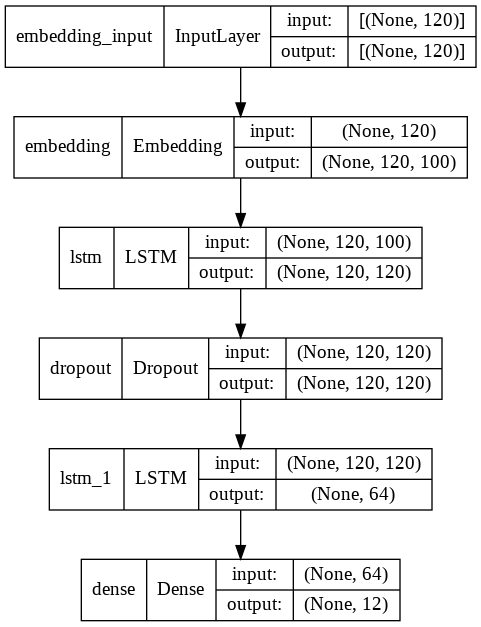

In [73]:
keras.utils.plot_model(model, show_shapes=True)

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          9438100   
                                                                 
 lstm (LSTM)                 (None, 120, 120)          106080    
                                                                 
 dropout (Dropout)           (None, 120, 120)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                47360     
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
Total params: 9,592,320
Trainable params: 154,220
Non-trainable params: 9,438,100
_________________________________________________________________


In [75]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Early stopping will be used when no more progress is seen on the validation data, especially on the loss

In [76]:
history = model.fit(X_train_pad, y_train, epochs=8, verbose = 1, batch_size = 50,
                    validation_data = (X_val_pad, y_val), callbacks=[early_stop])

Epoch 1/8
749/749 [==============================] - 175s 229ms/step - loss: 0.2802 - accuracy: 0.5976 - val_loss: 0.2390 - val_accuracy: 0.6006
Epoch 2/8
749/749 [==============================] - 172s 229ms/step - loss: 0.2285 - accuracy: 0.6178 - val_loss: 0.2181 - val_accuracy: 0.6232
Epoch 3/8
749/749 [==============================] - 172s 229ms/step - loss: 0.2130 - accuracy: 0.6210 - val_loss: 0.2099 - val_accuracy: 0.6597
Epoch 4/8
749/749 [==============================] - 172s 230ms/step - loss: 0.2035 - accuracy: 0.6204 - val_loss: 0.2029 - val_accuracy: 0.5931
Epoch 5/8
749/749 [==============================] - 172s 230ms/step - loss: 0.1952 - accuracy: 0.6235 - val_loss: 0.1994 - val_accuracy: 0.6179
Epoch 6/8
749/749 [==============================] - 172s 230ms/step - loss: 0.1887 - accuracy: 0.6243 - val_loss: 0.1959 - val_accuracy: 0.5953
Epoch 7/8
749/749 [==============================] - 173s 231ms/step - loss: 0.1817 - accuracy: 0.6276 - val_loss: 0.1991 - val_ac

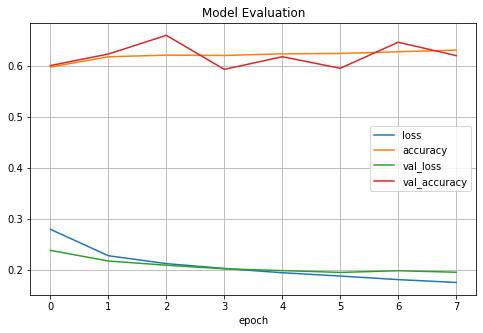

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.title('Model Evaluation')
plt.xlabel('epoch')
plt.show()

From the accuracy of training and validation data, it can be seen that the model doesn't appear to be overfitted

In [78]:
model.evaluate(X_val_pad,y_val)

131/131 [==============================] - 6s 46ms/step - loss: 0.1962 - accuracy: 0.6200


[0.19621653854846954, 0.6200432777404785]

In [79]:
pred = model.predict(X_val_pad)

In [80]:
pred[0][0]

0.5419282

In [81]:
pred.shape

(4161, 12)

To make model evaluation easier, we will transform the output of `pred` into 0 and 1

To do that, first make an array of zeros with the same shape of `pred`. In this case, we will name that array as `y_pred_model` and we will set the threshold as 0.5. If a value in `pred` is more than 0.5, we will change that value in `y_pred_model` to 1. If the value is less than 0.5, we'll keep the value in `y_pred_model` as 0

In [82]:
y_pred_model = np.zeros((len(pred),len(pred[0])))
y_pred_model

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
y_pred_model.shape

(4161, 12)

In [84]:
for i in range(len(pred)):
  for j in range(len(pred[i])):
    if pred[i][j] > 0.5:
        y_pred_model[i][j] = 1
    else :
        continue

In [85]:
y_pred_model[0]

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [86]:
y_val[0]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [87]:
print('Recommended genre tags:')
print()

for i in range(len(y_pred_model[0])):
  if y_pred_model[0][i] == 1:
    print(top_genre[i])
  else:
    continue

Recommended genre tags:

Fiction
Fantasy


In [88]:
print('Goodreads\'s genre tags:')
print()

for i in range(len(y_val[0])):
  if y_val[0][i] == 1:
    print(top_genre[i])
  else:
    continue

Goodreads's genre tags:

Fiction
Fantasy
Young Adult


# Model Evaluation

In [89]:
top_genre

['Fiction',
 'Fantasy',
 'Mystery',
 'Young Adult',
 'Historical Fiction',
 'Romance',
 'Nonfiction',
 'Biography',
 'History',
 'Religion',
 'Science',
 'Philosophy']

In [90]:
print(classification_report(y_val, y_pred_model, target_names = ['Fiction', 'Fantasy', 'Mystery', 'Young Adult', 'Historical Fiction', 'Romance',
                                                                 'Nonfiction', 'Biography', 'History', 'Religion', 'Science', 'Philosophy']))

                    precision    recall  f1-score   support

           Fiction       0.78      0.85      0.82      2173
           Fantasy       0.84      0.74      0.79      1172
           Mystery       0.64      0.65      0.65       505
       Young Adult       0.73      0.62      0.67       907
Historical Fiction       0.74      0.45      0.56       612
           Romance       0.79      0.73      0.76      1108
        Nonfiction       0.78      0.81      0.79       644
         Biography       0.66      0.58      0.62       236
           History       0.74      0.48      0.59       196
          Religion       0.76      0.34      0.46       167
           Science       0.72      0.43      0.54        83
        Philosophy       0.74      0.38      0.50       136

         micro avg       0.77      0.70      0.73      7939
         macro avg       0.74      0.59      0.64      7939
      weighted avg       0.77      0.70      0.73      7939
       samples avg       0.75      0.7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The performance of the model will be seen from the micro average score:
- Precision score: 0.77
- Recall score: 0.70
- F1 Score: 0.73

From the scores above, it can be said that the model has a pretty good performance

The performance of the model can also be seen from the performance of each genre label. It can be seen that genres that have a lot of data, such as Fiction, Fantasy, and Romance, have great precision and recall scores. Whereas the genres with fewer data tends to have low recall score, such as Religion, Philosophy, and Science


# Model Saving

The model and tokenizer will be saved for deployment purposes

In [91]:
joblib.dump(t, 'tokenizer.save') 

['tokenizer.save']

In [154]:
model.save('/content/gdrive/MyDrive/data hacktiv8/book_genre_model.h5')

# Model Inference

For the model inference, we will be choosing 4 random data from the test data and manually inputing the book description

In [93]:
X_test.iloc[45]

'morgan is a willful mischievous girl with mismatched eyes of emerald and violet a girl of magic whose childhood ends when king uther pendragon murders her father and steals away her mother then pendragon dies and in a warring country with no one to claim the throne there are many who want morgan dead but morgan has power and magic she is able to change the course of history to become other to determine her own fate and thus the fate of britain she will become morgan le fay springer wields language like a sword and both blood and flowers spring to these pages in vivid hues booklist starred review'

In [94]:
y_test[45]

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [95]:
inf = 'morgan is a willful mischievous girl with mismatched eyes of emerald and violet a girl of magic whose childhood ends when king uther pendragon murders her father and steals away her mother then pendragon dies and in a warring country with no one to claim the throne there are many who want morgan dead but morgan has power and magic she is able to change the course of history to become other to determine her own fate and thus the fate of britain she will become morgan le fay springer wields language like a sword and both blood and flowers spring to these pages in vivid hues booklist starred review'

In [96]:
txt_samp = pd.Series([inf])

In [97]:
txt_samp

0    morgan is a willful mischievous girl with mism...
dtype: object

In [98]:
 txt = preprocess_data(txt_samp)
 txt

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1979,  9227,  5760,    44, 12695,   260,
         7340,  2320,    44,   134,   112,   363,   845,   143, 19439,
        12279,  1460,    38,  4510,    89,    51, 12279,  1412,  6175,
          196,     1,  1016,  1176,    77,   144,  1979,   106,  1979,
           55,   134,   385,   152,   357,    58,    75,  3009,   227,
         2090,   227,  1576,    75,  1979,  3363, 16469, 25556,  8425,
          397,    21,  1283,   224,  3693,  1712,   596,   979, 27793,
         5461,  4580,  1362]], dtype=int32)

In [99]:
pred_inf = model.predict(txt)

In [100]:
pred_inf = pred_inf[0]
pred_inf

array([6.89356863e-01, 9.76292014e-01, 3.24510634e-02, 6.37018740e-01,
       1.18710846e-01, 6.46764934e-02, 5.56081533e-04, 2.70575285e-04,
       1.03473663e-03, 6.61075115e-04, 3.85552645e-04, 3.13520432e-04],
      dtype=float32)

In [101]:
len(pred_inf)

12

In [102]:
y_pred_inf = np.zeros((len(pred_inf)))
y_pred_inf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [103]:
for i in range(len(pred_inf)):
  if pred_inf[i] > 0.5:
    y_pred_inf[i] = 1
  else :
    continue

In [104]:
y_pred_inf

array([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [105]:
y_test[45]

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [106]:
for i in range(len(y_pred_inf)):
  if y_pred_inf[i] == 1:
    print(top_genre[i])
  else:
    continue

Fiction
Fantasy
Young Adult


In [107]:
for i in range(len(y_test[0])):
  if y_test[45][i] == 1:
    print(top_genre[i])
  else:
    continue

Fiction
Fantasy
Young Adult
Historical Fiction


***

In [108]:
X_test.iloc[87]

'sometimes fairy tales can come true even for plain shy spinsters like missy wright neither as pretty as cousin alicia nor as domineering as mother drusilla she seems doomed to a quiet life of near poverty at missalonghi her family is pitifully small homestead in australia is blue mountains but it is a brand new century the twentieth a time for new thoughts and bold new actions and missy wright is about to set every self righteous tongue in the town of byron wagging because she has just set her sights on a mysterious mistrusted and unsuspecting stranger who just might be prince charming in disguise'

In [109]:
y_test[87]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [110]:
inf = 'sometimes fairy tales can come true even for plain shy spinsters like missy wright neither as pretty as cousin alicia nor as domineering as mother drusilla she seems doomed to a quiet life of near poverty at missalonghi her family is pitifully small homestead in australia is blue mountains but it is a brand new century the twentieth a time for new thoughts and bold new actions and missy wright is about to set every self righteous tongue in the town of byron wagging because she has just set her sights on a mysterious mistrusted and unsuspecting stranger who just might be prince charming in disguise'

In [111]:
txt_samp = pd.Series([inf])

In [112]:
txt_samp

0    sometimes fairy tales can come true even for p...
dtype: object

In [113]:
 txt = preprocess_data(txt_samp)
 txt

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   408,   734,   419,    67,    86,
           14,  2394,  2140, 30907,    21, 23809,  4949,   991,   953,
         1310, 12258,  9588,    51, 44546,   170,  2420,   831,     2,
          633,  1784,    11, 49468,   159, 14187,  2715,   709,  1248,
         1555,     3,   137,  1049,     8,     3,  1109,  1654,     3,
         1917, 23809,  4949,    76,    48,   192,  9118,  4792,    93,
         6556, 23427,    76,  3218,   120, 45673,  6865,   578,   150,
          426,   929,  5261]], dtype=int32)

In [114]:
pred_inf = model.predict(txt)

In [115]:
pred_inf = pred_inf[0]
pred_inf

array([8.5520130e-01, 7.6726615e-01, 4.3730646e-02, 4.6431684e-01,
       5.2868998e-01, 4.3325171e-01, 2.4718940e-03, 1.2359321e-03,
       1.2410581e-03, 3.3849478e-03, 3.4657121e-04, 6.2540174e-04],
      dtype=float32)

In [116]:
len(pred_inf)

12

In [117]:
y_pred_inf = np.zeros((len(pred_inf)))
y_pred_inf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [118]:
for i in range(len(pred_inf)):
  if pred_inf[i] > 0.5:
    y_pred_inf[i] = 1
  else :
    continue

In [119]:
top_genre

['Fiction',
 'Fantasy',
 'Mystery',
 'Young Adult',
 'Historical Fiction',
 'Romance',
 'Nonfiction',
 'Biography',
 'History',
 'Religion',
 'Science',
 'Philosophy']

In [120]:
y_pred_inf

array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [121]:
y_test[87]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [122]:
for i in range(len(y_pred_inf)):
  if y_pred_inf[i] == 1:
    print(top_genre[i])
  else:
    continue

Fiction
Fantasy
Historical Fiction


In [123]:
for i in range(len(y_test[0])):
  if y_test[87][i] == 1:
    print(top_genre[i])
  else:
    continue

Fiction
Historical Fiction
Romance


***

In [124]:
X_test.iloc[213]

'i will put you in my diary comedian kenneth williams was known to threaten on occasion although tantalisingly he kept the journal to himself during his lifetime here at last in one spellbinding volume are four million words of it for more than forty years from his sixteenth birthday until the eve of his unexpected death in  the beloved actor and outrageous carry on star kenneth williams kept a candid diary devastatingly honest about himself he is equally unsparing in his verdicts on his fellow man in his descriptions of tony hancock maggie smith joe orton and countless others his waspish sense of humour love of anecdote and ear for dialogue are given full rein malicious hilarious and harrowing the kenneth williams diaries are a unique portrait of one of britain is most popular and most misunderstood performers'

In [125]:
y_test[213]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [126]:
inf = 'i will put you in my diary comedian kenneth williams was known to threaten on occasion although tantalisingly he kept the journal to himself during his lifetime here at last in one spellbinding volume are four million words of it for more than forty years from his sixteenth birthday until the eve of his unexpected death in  the beloved actor and outrageous carry on star kenneth williams kept a candid diary devastatingly honest about himself he is equally unsparing in his verdicts on his fellow man in his descriptions of tony hancock maggie smith joe orton and countless others his waspish sense of humour love of anecdote and ear for dialogue are given full rein malicious hilarious and harrowing the kenneth williams diaries are a unique portrait of one of britain is most popular and most misunderstood performers'

In [127]:
txt_samp = pd.Series([inf])

In [128]:
txt_samp

0    i will put you in my diary comedian kenneth wi...
dtype: object

In [129]:
 txt = preprocess_data(txt_samp)
 txt

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          273,  1300,  9052,  8718,  2541,   127,  1458,  7202,   892,
        30061,   982,  1194,  1018,    59,     1,  2257,   261,   157,
          799,   382,  1540,    12,  5401,  1162,   783,   456,    40,
          306,  2642,  2991,  2033,   354,  8718,  2541,   982,  4184,
         1300,  6057,  1585,  2336, 11604, 46955,  1030,    10,  3975,
         2564, 17779,  1684,  1342,  1260, 33194,  2012,   233,   411,
         3051,     5, 16071,  4412,  3746,   529,   153, 12863,  7986,
          816,  1550,  8718,  2541,  2568,   451,   743,     1,  1576,
          388,  6479, 10711]], dtype=int32)

In [130]:
pred_inf = model.predict(txt)

In [131]:
pred_inf = pred_inf[0]
pred_inf

array([0.10200867, 0.00689232, 0.00672722, 0.02221465, 0.00555912,
       0.01677439, 0.8630751 , 0.83093613, 0.0233089 , 0.00327021,
       0.00856   , 0.00357646], dtype=float32)

In [132]:
len(pred_inf)

12

In [133]:
y_pred_inf = np.zeros((len(pred_inf)))
y_pred_inf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [134]:
for i in range(len(pred_inf)):
  if pred_inf[i] > 0.5:
    y_pred_inf[i] = 1
  else :
    continue

In [135]:
y_pred_inf

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

In [136]:
y_test[213]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [137]:
for i in range(len(y_pred_inf)):
  if y_pred_inf[i] == 1:
    print(top_genre[i])
  else:
    continue

Nonfiction
Biography


In [138]:
for i in range(len(y_test[213])):
  if y_test[213][i] == 1:
    print(top_genre[i])
  else:
    continue

Nonfiction
Biography


***

In [139]:
X_test.iloc[25]

'when the vast wartime factories of the manhattan project began producing plutonium in quantities never before seen on earth scientists working on the top secret bomb building program grew apprehensive fearful that plutonium might cause a cancer epidemic among workers and desperate to learn more about what it could do to the human body the manhattan project is medical doctors embarked upon an experiment in which eighteen unsuspecting patients in hospital wards throughout the country were secretly injected with the cancer causing substance most of these patients would go to their graves without ever knowing what had been done to them now in the plutonium files pulitzer prize winning reporter eileen welsome reveals for the first time the breadth of the extraordinary fifty year cover up surrounding the plutonium injections as well as the deceitful nature of thousands of other experiments conducted on american citizens in the postwar years welsome is remarkable investigation spans the s to

In [140]:
y_test[25]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [141]:
inf = 'when the vast wartime factories of the manhattan project began producing plutonium in quantities never before seen on earth scientists working on the top secret bomb building program grew apprehensive fearful that plutonium might cause a cancer epidemic among workers and desperate to learn more about what it could do to the human body the manhattan project is medical doctors embarked upon an experiment in which eighteen unsuspecting patients in hospital wards throughout the country were secretly injected with the cancer causing substance most of these patients would go to their graves without ever knowing what had been done to them now in the plutonium files pulitzer prize winning reporter eileen welsome reveals for the first time the breadth of the extraordinary fifty year cover up surrounding the plutonium injections as well as the deceitful nature of thousands of other experiments conducted on american citizens in the postwar years welsome is remarkable investigation spans the s to the s and draws upon hundreds of newly declassified documents and other primary sources to disclose this shadowy chapter in american history she gives a voice to such innocents as helen hutchison a young woman who entered a prenatal clinic in nashville for a routine checkup and was instead given a radioactive cocktail to drink gordon shattuck one of several boys at a state school for the developmentally disabled in massachusetts who was fed radioactive oatmeal for breakfast and maude jacobs a cincinnati woman suffering from cancer and subjected to an experimental radiation treatment designed to help military planners learn how to win a nuclear war welsome also tells the stories of the scientists themselves many of whom learned the ways of secrecy on the manhattan project among them are stafford warren a grand figure whose bravado masked a cunning intelligence joseph hamilton who felt he was immune to the dangers of radiation only to suffer later from a fatal leukemia and physician louis hempelmann one of the most enthusiastic supporters of the plan to inject humans with potentially carcinogenic doses of plutonium hidden discussions of fifty years past are reconstructed here wherein trusted government officials debated the ethical and legal implications of the experiments demolishing forever the argument that these studies took place in a less enlightened era powered by her groundbreaking reportage and singular narrative gifts eileen welsome has created a work of profound humanity as well as major historical significance from the hardcover edition'

In [142]:
txt_samp = pd.Series([inf])

In [143]:
txt_samp

0    when the vast wartime factories of the manhatt...
dtype: object

In [144]:
 txt = preprocess_data(txt_samp)
 txt

array([[ 3297, 43085,   518,   529, 11136,  7190,  3230,  4467,     1,
          923,   527,   597,    62, 11138,  3970,  4415, 11136, 40106,
         6623, 13097,  6301, 18078,    32,  1447,  2424,  8214,  5400,
        11868,  2689,  1886,    52,   880, 35366,   189,   571,  2476,
           28,    43,   238,    84,  1769,    77,   810,   321,  5560,
         1723,  1598,   245, 15834,  4543,  1250,   671,   112, 16003,
         6187,  2249,   956,  2139,  3662,  1063,  6860,  1771, 11868,
         3079,   265,  2169, 15082,  4149,  2269,     1,  9471, 10469,
          427, 34593,   585,  5359, 89793, 20979, 42712,   319,  6891,
         1612,    12,    37, 19408, 16061,  2268,   608,  5930, 14867,
         5212,  2584,  4833,  4200, 29797,   156,  4132,  1916,   677,
           85,   593,  8828,  1055,  5900,  2121, 13856,  3403,   626,
         1613, 10721,   541,    41,  1167,   542,    63,   488,   459,
         4239,  1363,   126]], dtype=int32)

In [145]:
pred_inf = model.predict(txt)

In [146]:
pred_inf = pred_inf[0]
pred_inf

array([1.9031614e-02, 2.9169023e-02, 6.6355586e-02, 1.9778609e-03,
       6.1536431e-03, 6.4179301e-04, 9.6616471e-01, 2.5175121e-01,
       8.3251464e-01, 2.4634182e-02, 5.9646380e-01, 2.4240285e-02],
      dtype=float32)

In [147]:
len(pred_inf)

12

In [148]:
y_pred_inf = np.zeros((len(pred_inf)))
y_pred_inf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [149]:
for i in range(len(pred_inf)):
  if pred_inf[i] > 0.5:
    y_pred_inf[i] = 1
  else :
    continue

In [150]:
y_pred_inf

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.])

In [151]:
y_test[0]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [152]:
for i in range(len(y_pred_inf)):
  if y_pred_inf[i] == 1:
    print(top_genre[i])
  else:
    continue

Nonfiction
History
Science


In [153]:
for i in range(len(y_test[25])):
  if y_test[25][i] == 1:
    print(top_genre[i])
  else:
    continue

Nonfiction
History
Science
